In [89]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
warnings.simplefilter('ignore')
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('..\\..\\sqllite\\go_staff.sqlite')
conn2 = sqlite3.connect('..\\..\\sqllite\\go_sales.sqlite')

In [90]:
df = pd.read_sql_query("SELECT * FROM sales_branch", conn)
df02 = pd.read_sql_query("SELECT * FROM country", conn2)
df = pd.merge(df, df02, on='COUNTRY_CODE')
df = df.loc[:, ['CITY', 'REGION', 'COUNTRY']]
df.dtypes

CITY       object
REGION     object
COUNTRY    object
dtype: object

In [91]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['CITY', 'REGION', 'COUNTRY']])
dummies_dataframe

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,COUNTRY_Japan,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [92]:
# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dummies_dataframe)

In [94]:
# Choose the number of clusters (k)
k = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
dummies_dataframe["cluster"] = kmeans.fit_predict(data_scaled)

# Print the centroids of the clusters
print("Cluster Centers:")
print(scaler.inverse_transform(kmeans.cluster_centers_))

# Visualize the cluster assignments
dummies_dataframe

Cluster Centers:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.0

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States,cluster
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,1
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [95]:
# Drop the 'cluster' column before calculating cluster centers
dummies_dataframe_without_cluster = dummies_dataframe.drop(columns=['cluster'])

# Get cluster centers
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_, columns=dummies_dataframe_without_cluster.columns)

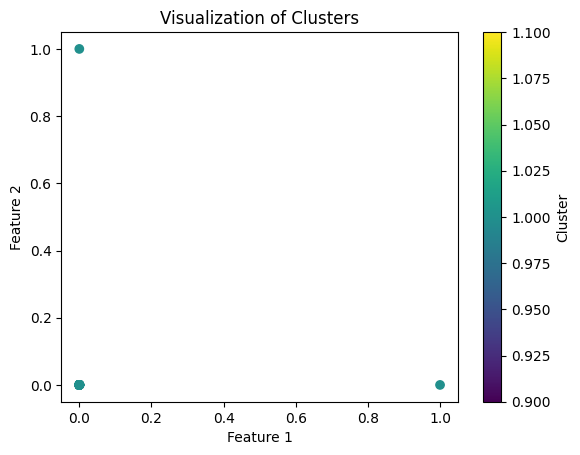

Centrum
1    28
dtype: int64


In [96]:
# Function to calculate Euclidean distance between data points and cluster centers
def calculate_distances(data, centroids):
    distances = {}
    for src_index, _ in data.iterrows():
        euclidean_distances = {}
        for centrum_index, _ in centroids.iterrows():
            euclidean_sum = 0
            for column_name in centroids.columns:
                current_difference = data.at[src_index, column_name] - centroids.at[centrum_index, column_name]
                euclidean_sum += current_difference ** 2
            euclidean_distance = math.sqrt(euclidean_sum)
            euclidean_distances[centrum_index] = euclidean_distance
        distances[src_index] = euclidean_distances
    return distances

# Assign labels to columns
kmeans_centra.columns = dummies_dataframe_without_cluster.columns

# Calculate distances and assign each data point to the nearest cluster center
distances = calculate_distances(dummies_dataframe_without_cluster, kmeans_centra)

# Add the cluster center to the dataframe
nearest_cluster_centers = {}
for src_index, distances_dict in distances.items():
    nearest_cluster_centers[src_index] = min(distances_dict, key=distances_dict.get)
dummies_dataframe_without_cluster['Centrum'] = nearest_cluster_centers.values()

# Plot the clusters
plt.scatter(dummies_dataframe_without_cluster.iloc[:, 0], dummies_dataframe_without_cluster.iloc[:, 1], c=dummies_dataframe_without_cluster['Centrum'], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Group by cluster centers and count data points in each cluster
print(dummies_dataframe_without_cluster.groupby('Centrum').size())